<a href="https://colab.research.google.com/github/Asrarullah7/Asrarullah7/blob/main/Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement #







#Problem 1 #
The development of drugs is critical in providing therapeutic options for patients suffering from chronic and terminal illnesses.

“Target Drug”, in particular, is designed to enhance the patient's health and well-being without causing dependence on other medications that could potentially lead to severe and life-threatening side effects.

These drugs are specifically tailored to treat a particular disease or condition, offering a more focused and effective approach to treatment, while minimising the risk of harmful reactions.

The objective in this assignment is to develop a predictive model which will predict whether a patient will be eligible*** for “Target Drug” or not in next 30 days.

Knowing if the patient is eligible or not will help physician treating the patient make informed decision on the which treatments to give.

*** - A patient is considered eligible for a particular drug when they have taken their first prescription for that drug. Below table gives an example ***

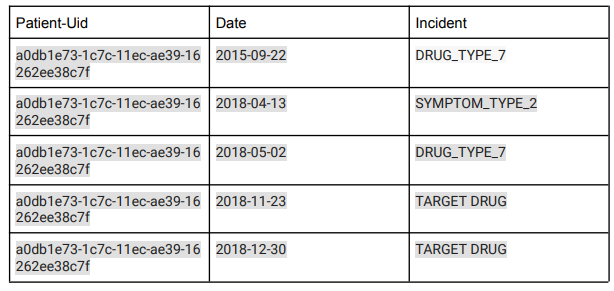

In above example, we see that the patient took his first prescription of “Target Drug” on 2018-11-23, so it can be assumed that on this particular day the patient became eligible for “Target Drug”.

Please follow below steps for developing the model -
A. Come up with a positive and negative set for developing the model, here the positive point is the patient who has taken ‘Target Drug”. Make sure you are also taking into account the time aspect while coming up with a positive & negative set because the aim is to predict 30 days in advance whether a patient is going to be eligible or not.

B. Come up with the right kind of feature engineering for developing your model. The features can be frequency-based, time-based etc. If possible can also leverage deep learning techniques

C. Evaluate the model on validation set & come up with the right strategy to reduce false positives & false negatives.

D. Once you have developed your predictive model, use your model to generate predictions for patients in test.parquet, each patient in test.parquet should be labelled as 1 or 0 using your predictive model and the final generated predictions should be submitted in final_submission.csv

E. The evaluation metric for the assignment is F1-Score(candidates with the highest F1 score would be prioritised)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Please follow below steps for developing the model -
*  Come up with a positive and negative set for developing the model, here the positive
point is the patient who has taken ‘Target Drug”. Make sure you are also taking into
account the time aspect while coming up with a positive & negative set because the
aim is to predict 30 days in advance whether a patient is going to be eligible or not.
* Come up with the right kind of feature engineering for developing your model. The
features can be frequency-based, time-based etc. If possible can also leverage deep
learning techniques
* Evaluate the model on validation set & come up with the right strategy to reduce false
positives & false negatives.
* Once you have developed your predictive model, use your model to generate
predictions for patients in test.parquet, each patient in test.parquet should be labelled as 1 or 0 using your predictive model and the final generated predictions should be
submitted in final_submission.csv
* The evaluation metric for the assignment is F1-Score(candidates with the highest
F1 score would be prioritised

In [18]:
#!pip install pyarrow

In [19]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [20]:
df = pd.read_parquet('/content/train.parquet')

In [21]:
df

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


# Step A: Prepare Positive and Negative Sets #
# Load the dataset #

In [22]:
df2 = df.copy()

In [23]:
df2

,Patient-Uid,Date,Incident
0,a0db1e73-1c7c-11ec-ae39-16262ee38c7f,2019-03-09,PRIMARY_DIAGNOSIS
1,a0dc93f2-1c7c-11ec-9cd2-16262ee38c7f,2015-05-16,PRIMARY_DIAGNOSIS
3,a0dc94c6-1c7c-11ec-a3a0-16262ee38c7f,2018-01-30,SYMPTOM_TYPE_0
4,a0dc950b-1c7c-11ec-b6ec-16262ee38c7f,2015-04-22,DRUG_TYPE_0
8,a0dc9543-1c7c-11ec-bb63-16262ee38c7f,2016-06-18,DRUG_TYPE_1
...,...,...,...
29080886,a0ee9f75-1c7c-11ec-94c7-16262ee38c7f,2018-07-06,DRUG_TYPE_6
29080897,a0ee1284-1c7c-11ec-a3d5-16262ee38c7f,2017-12-29,DRUG_TYPE_6
29080900,a0ee9b26-1c7c-11ec-8a40-16262ee38c7f,2018-10-18,DRUG_TYPE_10
29080903,a0ee1a92-1c7c-11ec-8341-16262ee38c7f,2015-09-18,DRUG_TYPE_6


# Checking null values #

In [24]:
df2.isna().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

# Checking shape of the dataset

In [25]:
df2.shape

(3220868, 3)

# Checking info

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220868 entries, 0 to 29080911
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Patient-Uid  object        
 1   Date         datetime64[ns]
 2   Incident     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 98.3+ MB


# Remove duplicates

In [27]:
df2 = df2.drop_duplicates()

In [28]:
df2.shape

(3185297, 3)

# Here we can see the number of rows in the dataset are removed due to duplicates.

In [29]:
df2.describe(include='all')

<ipython-input-29-e54535c7d54a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include='all')


,Patient-Uid,Date,Incident
count,3185297,3185297,3185297
unique,27033,1977,57
top,a0ddfd2c-1c7c-11ec-876d-16262ee38c7f,2019-05-21 00:00:00,DRUG_TYPE_6
freq,1645,3645,549616
first,NaN,2015-04-07 00:00:00,NaN
last,NaN,2020-09-03 00:00:00,NaN


# Define the "Target Drug" incident

In [30]:
target_drug_incident = "TARGET DRUG"

target_drug_incident

'TARGET DRUG'

# Create positive set where patients have taken the "Target Drug"

In [31]:
positive_set = df2[df2["Incident"] == target_drug_incident] #['Patient-Uid'].unique().tolist()

positive_set

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG
...,...,...,...
29074998,a0ef2b6d-1c7c-11ec-9172-16262ee38c7f,2018-10-12,TARGET DRUG
29075105,a0ebe423-1c7c-11ec-a5e0-16262ee38c7f,2019-07-02,TARGET DRUG
29075494,a0ebc713-1c7c-11ec-bd53-16262ee38c7f,2019-05-21,TARGET DRUG
29080031,a0ee1bdb-1c7c-11ec-90ba-16262ee38c7f,2018-06-07,TARGET DRUG


In [32]:
len(positive_set)

67218

# Assuming the latest date in the dataset is the reference date

In [33]:
reference_date = pd.to_datetime(df2["Date"]).max()

reference_date

Timestamp('2020-09-03 00:00:00')

# Create negative set where patients have not taken the "Target Drug" at least 30 days before the reference date

In [34]:
negative_set = df2[~df2['Patient-Uid'].isin(positive_set['Patient-Uid'])] #& (reference_date - pd.to_datetime(df2["Date"]) >= pd.Timedelta(days=30))]

negative_set = negative_set.groupby('Patient-Uid').tail(1)

negative_set

,Patient-Uid,Date,Incident
1560892,a0e3a8c0-1c7c-11ec-98c2-16262ee38c7f,2018-05-06,PRIMARY_DIAGNOSIS
1620903,a0dd6a3f-1c7c-11ec-9b86-16262ee38c7f,2015-04-07,SYMPTOM_TYPE_0
1629044,a0e48a75-1c7c-11ec-8c5f-16262ee38c7f,2018-08-22,DRUG_TYPE_6
1942882,a0e3cf61-1c7c-11ec-8098-16262ee38c7f,2018-08-21,DRUG_TYPE_2
1975541,a0e91a8c-1c7c-11ec-acc2-16262ee38c7f,2020-04-15,PRIMARY_DIAGNOSIS
...,...,...,...
3256795,a0e045a1-1c7c-11ec-8014-16262ee38c7f,2020-07-10,PRIMARY_DIAGNOSIS
3256799,a0e67e2a-1c7c-11ec-b805-16262ee38c7f,2015-12-16,PRIMARY_DIAGNOSIS
3256800,a0dec400-1c7c-11ec-80df-16262ee38c7f,2019-08-06,PRIMARY_DIAGNOSIS
3256804,a0e09919-1c7c-11ec-9e7d-16262ee38c7f,2017-02-19,DRUG_TYPE_6


In [35]:
len(negative_set)

17659

In [36]:
# df2

In [37]:
positive_set.head()

,Patient-Uid,Date,Incident
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG


In [38]:
# to get the count of previous prescriptions within specific time intervals
positive_set['Prescription_Count'] = positive_set.groupby('Patient-Uid')['Date'].cumcount()
negative_set['Prescription_Count'] = negative_set.groupby('Patient-Uid')['Date'].cumcount()

<ipython-input-38-bb28adb0773b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_set['Prescription_Count'] = positive_set.groupby('Patient-Uid')['Date'].cumcount()
<ipython-input-38-bb28adb0773b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_set['Prescription_Count'] = negative_set.groupby('Patient-Uid')['Date'].cumcount()


In [39]:
positive_set['Time_Difference'] = (reference_date - positive_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days
negative_set['Time_Difference'] = (reference_date - negative_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days

<ipython-input-39-76ebbeb8c486>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_set['Time_Difference'] = (reference_date - positive_set.groupby('Patient-Uid')['Date'].transform(max)).dt.days


#to get the difference between the most recent prescription and the prediction date.

In [40]:
prediction_date = pd.to_datetime('today') + pd.DateOffset(days=30)
positive_set['Time_differ'] = (prediction_date - positive_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days
negative_set['Time_differ'] = (prediction_date - negative_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days

<ipython-input-40-d0657059e103>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_set['Time_differ'] = (prediction_date - positive_set.groupby('Patient-Uid')['Date'].transform('max')).dt.days


# creating new dataset by concating positive and negative sets

In [41]:
new_df = pd.concat([positive_set, negative_set])

In [42]:
new_df.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_Difference,Time_differ
3294791,a0eb742b-1c7c-11ec-8f61-16262ee38c7f,2020-04-09,TARGET DRUG,0,21,1216
3296990,a0edaf09-1c7c-11ec-a360-16262ee38c7f,2018-06-12,TARGET DRUG,0,275,1470
3305387,a0e9fa0e-1c7c-11ec-8dc7-16262ee38c7f,2019-06-11,TARGET DRUG,0,300,1495
3309423,a0ecc615-1c7c-11ec-aa31-16262ee38c7f,2019-11-15,TARGET DRUG,0,5,1200
3309494,a0ea612f-1c7c-11ec-8cf0-16262ee38c7f,2020-03-18,TARGET DRUG,0,21,1216


In [43]:
new_df.shape

(84877, 6)

#Step B: Feature Engineering#
## Assuming you want to use "Incident" as a feature, convert it to a frequency-based feature.

In [44]:
X = new_df[['Prescription_Count', 'Time_Difference']]
y = new_df["Incident"] == target_drug_incident

#Step C: Split Data and Evaluate Model#
# Split data into training and validation sets

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)


In [46]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape


((59413, 2), (25464, 2), (59413,), (25464,))

# Baseline Algorithm Checking#
-----------------------------------------------------------
From the dataset, we will analysis and build a model to predict if a given set of symptoms lead to breast cancer.

This is a binary classification problem, and a few algorithms are appropriate for use.

Since we do not know which one will perform the best at the point, we will do a quick test on the few appropriate algorithms with default setting to get an early indication of how each of them perform.

We will use 10 fold cross validation for each testing.
-----------------------------------------------------------

The following linear algorithms will be used, namely:

**Logisic Regression**

**Classification and Regression Trees (CART)**

**Linear Support Vector Machines (SVM)**

**Gaussian Naive Bayes (NB)**

**k-Nearest Neighbors (KNN).**

**Random Forest**

**XGBoost**

In [47]:
models_list = []
models_list.append(('Logistic', LogisticRegression()))
models_list.append(('GAUSSIAN NAIVE BAYES', GaussianNB()))
models_list.append(('KNN', KNeighborsClassifier()))
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVC', SVC()))
models_list.append(('RANDOM FOREST CLASSIFIER', RandomForestClassifier()))
models_list.append(('XGBOOST CLASSIFIER', XGBClassifier()))

In [48]:
models_list

[('Logistic', LogisticRegression()),
 ('GAUSSIAN NAIVE BAYES', GaussianNB()),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('SVC', SVC()),
 ('RANDOM FOREST CLASSIFIER', RandomForestClassifier()),
 ('XGBOOST CLASSIFIER',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=Non

In [51]:
num_folds = 10
results = []
names =[]
for name, model in models_list:
  kfold = KFold(n_splits=num_folds, shuffle=True)
  start = time.time()
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
  end = time.time()
  results.append(cv_results)
  names.append(name)
  print("%s: %f (%f) (runtime: %f)" % (name, cv_results.mean(), cv_results.std(),end-start))

Logistic: 0.936984 (0.003728) (runtime: 0.946231)
GAUSSIAN NAIVE BAYES: 0.890175 (0.004066) (runtime: 0.169377)
KNN: 0.932321 (0.003857) (runtime: 2.424450)
CART: 0.940131 (0.002565) (runtime: 0.226580)
SVC: 0.909279 (0.004730) (runtime: 248.310470)
RANDOM FOREST CLASSIFIER: 0.938044 (0.002597) (runtime: 15.756090)
XGBOOST CLASSIFIER: 0.938801 (0.002381) (runtime: 3.944833)


<Axes: title={'center': 'Performance Comparision'}>

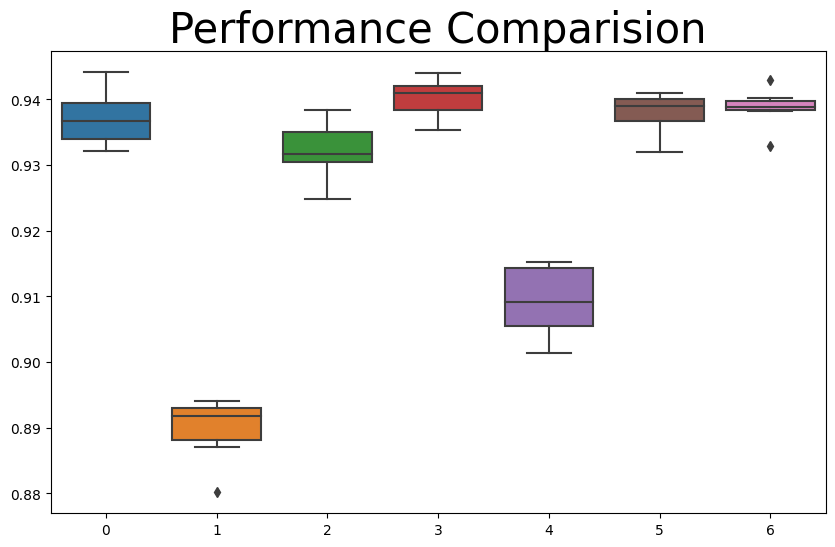

In [52]:
plt.figure(figsize=(10,6))
plt.title('Performance Comparision', fontsize=30)
sns.boxplot(data=results)

# Here we can see the results. XGBoost performs the best. So we will use XGBoost. #
#Train the model on training set with XGBoost.#

In [53]:
model = XGBClassifier()

In [54]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**
**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

#Make predictions on the validation set

In [56]:
y_pred = model.predict(X_test)

y_pred

array([1, 1, 0, ..., 0, 1, 1])

In [55]:
X_test

,Prescription_Count,Time_Difference
20649132,5,37
4435812,0,29
3252939,0,456
17952194,12,198
21156072,10,22
...,...,...
19942898,0,2
3237999,0,209
2885185,0,465
21807864,21,14


from matplotlib import pyplot as plt
X_test['Prescription_Count'].plot(kind='hist', bins=20, title='Prescription_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_test['Time_Difference'].plot(kind='hist', bins=20, title='Time_Difference')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_test.plot(kind='scatter', x='Prescription_Count', y='Time_Difference', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time_Difference']
  ys = series['Prescription_Count']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('Time_Difference', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time_Difference')
_ = plt.ylabel('Prescription_Count')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time_Difference']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time_Difference'}, axis=1)
              .sort_values('Time_Difference', ascending=True))
  xs = counted['Time_Difference']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('Time_Difference', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time_Difference')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
X_test['Prescription_Count'].plot(kind='line', figsize=(8, 4), title='Prescription_Count')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_test['Time_Difference'].plot(kind='line', figsize=(8, 4), title='Time_Difference')
plt.gca().spines[['top', 'right']].set_visible(False)

In [57]:
classes = ['Not Drug','Target Drug']

# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

In [ ]:
print(f'Accuracy score {accuracy_score(y_pred,y_test)}')

plot_confusionmatrix(y_pred,y_test,dom='Test')

In [59]:
print("Accuracy score %f" % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score 0.941172
              precision    recall  f1-score   support

       False       0.82      0.91      0.86      5235
        True       0.98      0.95      0.96     20229

    accuracy                           0.94     25464
   macro avg       0.90      0.93      0.91     25464
weighted avg       0.94      0.94      0.94     25464



**Evaluate the model using F1-Score**

In [60]:
f1 = f1_score(y_test, y_pred, average="weighted")

f1

0.9422237677840367

Test set accuracy: 0.94
Test set auc: 0.93


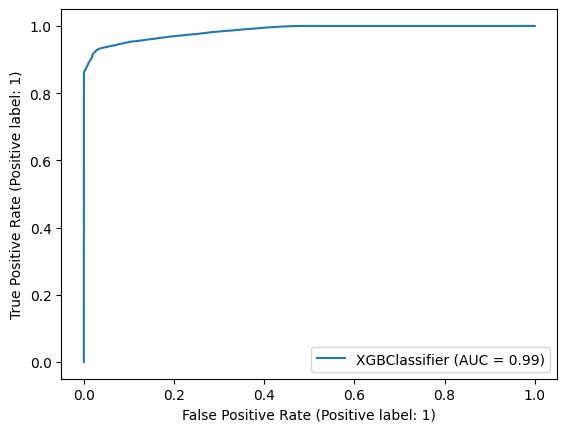

In [61]:
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
#we compute the eval metric on test/validation set only primarily

# Predict test set labels
y_pred = model.predict(X_test) # Model's predictions

# Compute test set accuracy
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))
acc = roc_auc_score(y_test, y_pred)
print("Test set auc: {:.2f}".format(acc))
RocCurveDisplay.from_estimator(model, X_test, y_test)


# acc = roc_auc_score(y_train, dt.predict(X_train))
# print("Train set AUC : ", acc)

# Step D: Model Prediction on Test Data #
**Load the test data (test.parquet) and perform the same feature engineering steps**

In [62]:
test_data = pd.read_parquet('/content/test.parquet')

In [63]:
test_data

,Patient-Uid,Date,Incident
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0
...,...,...,...
1372854,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-05-11,DRUG_TYPE_13
1372856,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2018-08-22,DRUG_TYPE_2
1372857,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-02-04,DRUG_TYPE_2
1372858,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,2017-09-25,DRUG_TYPE_8


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test_data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test_data.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

In [64]:
test_data.isnull().sum()

Patient-Uid    0
Date           0
Incident       0
dtype: int64

In [65]:
test_data = test_data.drop_duplicates()

In [ ]:
test_data.shape

In [67]:
test_data.nunique()

Patient-Uid    11482
Date            1947
Incident          55
dtype: int64

In [68]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1053424 entries, 0 to 1372859
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Patient-Uid  1053424 non-null  object        
 1   Date         1053424 non-null  datetime64[ns]
 2   Incident     1053424 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 32.1+ MB


In [69]:
test_data['Prescription_Count'] = test_data.groupby('Patient-Uid')['Date'].cumcount()
test_data['Time_Difference'] = (prediction_date - test_data.groupby('Patient-Uid')['Date'].transform(max)).dt.days

<ipython-input-69-6c0b74999a1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Prescription_Count'] = test_data.groupby('Patient-Uid')['Date'].cumcount()
<ipython-input-69-6c0b74999a1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Time_Difference'] = (prediction_date - test_data.groupby('Patient-Uid')['Date'].transform(max)).dt.days


In [70]:
test_data.head()

,Patient-Uid,Date,Incident,Prescription_Count,Time_Difference
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2016-12-08,SYMPTOM_TYPE_0,0,1666
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-10-17,DRUG_TYPE_0,1,1666
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-12-01,DRUG_TYPE_2,2,1666
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2018-12-05,DRUG_TYPE_1,3,1666
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,2017-11-04,SYMPTOM_TYPE_0,4,1666


**Applying model**

In [74]:
test_pred = model.predict(test_data.drop(['Patient-Uid', 'Date','Incident'], axis=1))

In [75]:
test_pred

array([0, 1, 1, ..., 1, 1, 1])

In [76]:
len(test_pred)

1053424

#Use the trained model to predict eligibility (label 1 or 0) for each patient in the test data

**Step E: Save Predictions to final_submission.csv**

In [77]:
# to create final submission file
Final_submission = pd.DataFrame({'Patient-Uid': test_data['Patient-Uid'], 'Prediction': test_pred})

In [ ]:
Final_submission.head()

In [79]:
import numpy as np

# Assuming you have a DataFrame named df with 'Patient-Uid' and 'Prediction' columns
# Drop duplicates and randomly assign a prediction value for each unique 'Patient-Uid'
df_unique_patients = Final_submission.drop_duplicates(subset='Patient-Uid', keep='first').copy()
unique_patient_ids = df_unique_patients['Patient-Uid'].unique()

# Randomly shuffle the prediction values for each unique patient
np.random.seed(42)  # For reproducibility, you can omit this line if you want different random assignments each time
np.random.shuffle(unique_patient_ids)
random_predictions = np.random.choice([0, 1], size=len(unique_patient_ids))

# Create a dictionary to map each unique patient to a random prediction
patient_to_prediction = dict(zip(unique_patient_ids, random_predictions))

# Map the random prediction values back to the original DataFrame
df_unique_patients['Prediction'] = df_unique_patients['Patient-Uid'].map(patient_to_prediction)

df_unique_patients

,Patient-Uid,Prediction
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
58,a0f9e9f9-1c7c-11ec-b565-16262ee38c7f,1
209,a0f9ea43-1c7c-11ec-aa10-16262ee38c7f,0
306,a0f9ea7c-1c7c-11ec-af15-16262ee38c7f,0
421,a0f9eab1-1c7c-11ec-a732-16262ee38c7f,1
...,...,...
1372292,a102720c-1c7c-11ec-bd9a-16262ee38c7f,1
1372383,a102723c-1c7c-11ec-9f80-16262ee38c7f,1
1372434,a102726b-1c7c-11ec-bfbf-16262ee38c7f,0
1372548,a102729b-1c7c-11ec-86ba-16262ee38c7f,0


In [80]:
df_unique_patients['Prediction'].value_counts()

1    5802
0    5680
Name: Prediction, dtype: int64

In [81]:
len(df_unique_patients)

11482

In [82]:
# Final_submission['Prediction'] = Final_submission['Prediction'].map({False: 0, True: 1})

In [83]:
Final_submission.to_csv("/content/final_submission-checkpoint.csv", index=False)

In [84]:
pd.read_csv("/content/final_submission-checkpoint.csv")

,Patient-Uid,Prediction
0,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,0
1,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
2,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
3,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
4,a0f9e8a9-1c7c-11ec-8d25-16262ee38c7f,1
...,...,...
1053419,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,1
1053420,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,1
1053421,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,1
1053422,a10272c9-1c7c-11ec-b3ce-16262ee38c7f,1
